# Technical Test for Seedbox

In [78]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import io
from scipy import stats

#useful helper functions are below

def add(t, d):
    key = t[1]
    if key in d:
        array = d[key] # array = [rebill#, refund#, chargeback#, gains, losses]
    else:
        array = [0,0,0,0,0]
    if t[2]=="\"REBILL\"":
        array[0]+=1
        array[3]+=float(t[3])
    elif t[2] == "\"REFUND\"":
        array[1]+=1
        array[4]+=float(t[3])
    else: # chargeback
        array[2]+=1
        array[4]+=float(t[3])
    d[key]=array

#Helper to calc probabilities
def probCalc(nDict):
    PRb = PRf = PCb = 0 # set p of Rebill, Refund, and Chargeback
    for key, val in nDict.items():
        PRb += val[0]
        PRf += val[1]
        PCb += val[2]
    Tot = PRb + PRf + PCb
    PRb = PRb/Tot
    PRf = PRf/Tot
    PCb = PCb/Tot
    return PRb, PRf, PCb

# Helper to calculate revenue (also get components of revenue; gains and losses)
def RevCalc(nDict):
    gain = loss = 0
    for key,val in nDict.items():
        gain+=val[3]
        loss+=val[4]
    rev = gain+loss # because loss is a negative number
    return gain, loss, rev

# Helper for counting users, the index i refers to rebill = 0, refund = 1, and chargeback = 2
def count(nDict, i): 
    count = 0
    for key,val in nDict.items():
        if val[i]>0:
            count+=1
    return count

#Reading files
f1 = open('../input/testSamples.csv','r')
group = []
header = f1.readline()
for line in f1:
    line = line.strip()
    tokens = line.split(",")
    group.append(int(tokens[1]))

trans = []
f2 = open('../input/transData.csv', 'r')
header2 = f2.readline()
for line in f2:
    line = line.strip()
    tokens = line.split(",")
    trans.append(tokens)

# sample ID is sample index
tDict = {}
cDict = {}
for t in trans:
    sID = int(t[1])
    if group[sID]==0: # control
        add(t, cDict)
    else: # test
        add(t, tDict)
#   tDict is test list; call-in
#   cDict is control; web-form

['testSamples.csv', 'transData.csv']


## Question 1: Probability Distribution

Probability Distribution: 


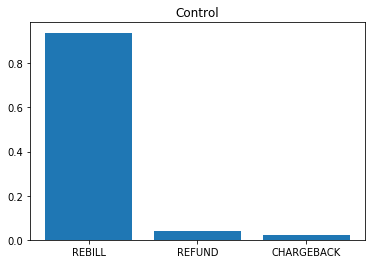

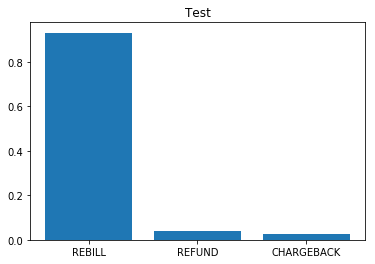

In [104]:
import matplotlib.pyplot as plt
#    What is the aproximate probability distribution between the test group and the control group
Pctrl = list(probCalc(cDict))
Ptest = list(probCalc(tDict))
xLabels = ["REBILL", "REFUND", "CHARGEBACK"]
print("Probability Distribution: ")
plt.bar(xLabels, Pctrl)
plt.title("Control")
plt.show()
plt.bar(xLabels, Ptest)
plt.title("Test")
plt.show()

## Q 2: Is a user that must call-in to cancel more likely to generate at least 1 additional REBILL?

In [105]:

#    compare t vs c at Rebills (% of ppl that rebill)
PCRebill = count(cDict, 0)/len(cDict)
PTRebill = count(tDict, 0)/len(tDict)
print("Answer according to average rebills: ", PTRebill>PCRebill)
print("mean Test rebill count: ", PTRebill, "\nmean Control rebill count: ", PCRebill)

#First get data as [yes rebill, no rebill]
Cvals = [0,0]
c = []
Tvals = [0,0]
t = []
for key,val in cDict.items():
    if (val[0]>0):
        Cvals[0]+=1
        c.append(1)
    else:
        Cvals[1]+=1
        c.append(0)
for key,val in tDict.items():
    if val[0]>0:
        Tvals[0]+=1
        t.append(1)
    else:
        Tvals[1]+=1
        t.append(0)
sig = stats.chisquare(f_obs=Tvals,f_exp=Cvals)
print("Chi squared test answers: \n", sig)

sig2 = stats.ttest_ind(c,t)
print("According to t-test: \n", sig2)




Answer according to average rebills:  True
mean Test rebill count:  0.9212962962962963 
mean Control rebill count:  0.9196515004840271
Chi squared test answers: 
 Power_divergenceResult(statistic=973.2523589093215, pvalue=1.1703553710034553e-213)
According to t-test: 
 Ttest_indResult(statistic=-0.13463928884817275, pvalue=0.8929070673835524)


Although the chi square indicates that the numbers are extremely related in both test and control groups and the average is higher for test-groups rebilling, the t-test indicates that this difference in values is not significant between control and test groups.

**Answer: ** There is no major significance between the web-form users and call-in users when it comes to generating additional rebills

## Question 3: Is a user that must call-in to cancel more likely to generate more revenues?

In [106]:
cTotals = RevCalc(cDict)
tTotals = RevCalc(tDict)
cRev = cTotals[2]/len(cDict)
tRev = tTotals[2]/len(tDict)
# can also treat individual revenues via standard deviation, chose to use means

print( tRev>cRev, "\nmean Test revenue: ", tRev,"\nmean Control revenue: ", cRev)
print("Control gain vs loss: ", cTotals[0]/len(cDict), cTotals[1]/len(cDict), "\nTest gain vs loss: ", tTotals[0]/len(tDict), tTotals[1]/len(tDict))

tRevList = [val[3]+val[4] for key,val in tDict.items()]
cRevList = [val[3]+val[4] for key,val in cDict.items()]
sig = stats.ttest_ind(cRevList,tRevList)
print("According to t-test: \n", sig)


False 
mean Test revenue:  64.60655864197533 
mean Control revenue:  69.41304453049337
Control gain vs loss:  74.06227008712453 -4.649225556631171 
Test gain vs loss:  69.77824074074076 -5.17168209876543
According to t-test: 
 Ttest_indResult(statistic=1.3602781012520437, pvalue=0.17385498722854761)


The averages between control and test revenues indicate that the control actually makes more money (using the webform). Furthermore, using the t-test it is evident that this is not very significant, with p of 0.17

**Answer: ** Users who must call-in are not more likely to generate more revenue compared to the web-form, in fact the web-form users have a higher revenue on average

## Question 4: Is a user that must call-in more likely to produce a higher chargeback rate?




In [107]:
#    Is a user that must call-in more likely to produce a higher chargeback rate(CHARGEBACKs/REBILLs)?
    # can also compare the variance in chargeback and variance in rebill, but chose not to because sample is not random (biased distribution)
    # therefore, calculate average chargebacks and average rebills
TRate = count(tDict,0)/count(tDict,2)/len(tDict)
CRate = count(cDict,0)/count(cDict,2)/len(cDict)
print(TRate>CRate)

tRevList = [val[3]/val[4] for key,val in tDict.items() if((val[0]>0)&(val[2]>0))]
cRevList = [val[3]/val[4] for key,val in cDict.items() if((val[0]>0)&(val[2]>0))]
sig = stats.ttest_ind(cRevList,tRevList)
print("According to t-test: ", sig)

True
According to t-test:  Ttest_indResult(statistic=1.1225749055651701, pvalue=0.30452063558041104)


When looking at average chargeback rates, the test group is larger. 

The rate for the Test is:  **0.043871252204585535 **

The rate for the Control is:  **0.015076254106295527**

However, according to the t-test this is not significant (high p value).

**Answer:** Users who call in have a higher average chargeback rate, however, the test requires more power to prove significance